# [Qiskit Bootcamp Part 0: Introduction to Qiskit and IBM Q](https://docs.google.com/presentation/d/1Y--23RhBtemLSxkFG40uhmMKpX-QJw6xL9WpA1ZUq2s/edit#slide=id.p)

Note: Search for the 📒emoji to see all the notebooks linked in this deck.

![Qiskit](https://github.com/Qiskit/qiskit-tutorials/raw/115c78962dda85bac29d679063b7d0d0ab1d1ab4/images/qiskit-heading.gif)

# Qiskit Bootcamp Parts I & II: Building and Executing Quantum Circuits with Terra, Aer, & IBM Q

donny@ibm.com <br>_23-Apr-19_

In [1]:
# **Note:** This notebook can be presented as a deck by uncommenting and running:
#!jupyter nbconvert ./Qiskit_Bootcamp_Terra.ipynb --to slides --post serve

# Or by installing RISE: https://damianavila.github.io/RISE/.

# Gameplan

* Part I: Constructing and Compiling Circuits in Terra
    * Circuit Construction Basics
    * Structural Elements
    * Compilation Flow, Transpilation
* Part II: Executing Circuits on Aer, BasicAer, and IBMQ
  * Aer basics
    * Ideal simulation
    * Noiseless sampling simulation
  * IBM Q Basics
    * Browsing device info
    * Building and executing noise model from device properties
    * Executing on quantum hardware
* Tips and tricks
* Learning More, Resources
* Resources for Quantum Algorithm Building Blocks

But first, install Terra, Aer, and IBM Q (and Ignis):

In [2]:
#!pip install qiskit

# Part I: Constructing and Compiling Circuits in Terra

# What is Terra?

Right now (Version ~0.8) Terra’s core service is the construction and compilation of Quantum executables (circuits and pulse schedules) for arbitrary backends
   * Terra includes interfaces for the construction of OpenQASM-compliant circuits and OpenPulse-compliant pulse schedules - see the [paper here](https://arxiv.org/abs/1809.03452)
   * Terra can take a single circuit or pulse object and compile it to run on any OpenQASM or OpenPulse compliant Quantum hardware or simulator
   * Terra also optimizes circuits, and allows for plug-and-play transpilation options
   
**Today we will only focus on circuits, not pulse schedules, because pulse v0 is being released presently.**

In the future, Terra will include:

  * More convenience operations for constructing sophisticated circuits
  * Richer set of tools for Quantum Information (Operators, Channels, States, etc.)

Keep in mind:

  * Terra is not a language per se, but more of a large piece of infrastructure. Some code may seem unnecessary for the one thing you’re doing, but in many cases it’s necessary for Qiskit to be robust.
  * Qiskit is very much a work in progress. It is changing rapidly to converge toward the needs of its users. 

🎉**You are now in the inner circle of people who have a strong voice about the direction of Qiskit.** 🎉

In [3]:
# Housekeeping: uncomment this to suppress deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Structural Elements

Let's start building circuits to get acquainted with Terra's structural elements.

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np

In [5]:
# Create a Quantum Register with 3 qubits
qr = QuantumRegister(3)

# Create a Classical Register with 3 bits
# Only necessary if you want to do measurement!
cr = ClassicalRegister(3)

# Create a Quantum Circuit acting on the qr and cr register
bell = QuantumCircuit(qr, cr)

# QuantumCircuits are the primary unit of computation in Terra
* QuantumCircuits are backend agnostic
* They contain 3 instance variables:
  * `name` - for referencing the circuit later (e.g. in the results object)
  * `data` - a 1d list of tuples containing `Instructions` in the circuit and the registers they act upon
  * `regs` - the `QuantumRegisters` and `ClassicalRegisters` in the instructions of the circuit
    * Behind the scenes these are mostly labels, they do not have any fancy instance methods


# I highly recommend scrolling through the `QuantumCircuit` module to gain a feel for what it can do:

In [6]:
help(QuantumCircuit)

Help on class QuantumCircuit in module qiskit.circuit.quantumcircuit:

class QuantumCircuit(builtins.object)
 |  Quantum circuit.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, rhs)
 |      Overload + to implement self.combine.
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __getitem__(self, item)
 |      Return indexed operation.
 |  
 |  __iadd__(self, rhs)
 |      Overload += to implement self.extend.
 |  
 |  __init__(self, *regs, name=None)
 |      Create a new circuit.
 |      A circuit is a list of instructions bound to some registers.
 |      Args:
 |          *regs (list(Register) or list(Int)): To be included in the circuit.
 |                - If [Register], the QuantumRegister and/or ClassicalRegister
 |                  to include in the circuit.
 |                  E.g.: QuantumCircuit(QuantumRegister(4))
 |                        QuantumCircuit(QuantumRegister(4), ClassicalRegister(3))
 |                        QuantumCircuit(QuantumRegister(4, 

# Gates! There are many. And they're called `Instructions`.

Qiskit supports many gates. They are located in the `qiskit/extensions/standard directory`, but are loaded in sneakily so you don’t need to import them one by one.

The basis gateset of the IBM Q devices is {u1, u2, u3, CX}, so you might find that a lot of code uses u3 for all single-qubit operations, rather than rx, ry, or rz.

Gates are technically objects, but in practice you're likely to use them in the form of static functions on the circuit object. Don't go looking for these functions in the QuantumCircuit class, they're dynamically added by each gate module import 🙈. More info on gates [here](https://github.com/Qiskit/qiskit-tutorial/blob/master/qiskit/terra/summary_of_quantum_operations.ipynb) 📒.

After we add some gates, we can print our circuit's Qasm:

In [7]:
# Hadamard gate on qubit 0
bell.h(qr[0])

# CNOT (Controlled-NOT) gate from qubit 0 to qubit 1
bell.cx(qr[0], qr[1])

print(bell.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
creg c0[3];
h q0[0];
cx q0[0],q0[1];



Here we've added an H gate to qubit 0 in register `qr`, and a CX gate from qubit 0 to qubit 1 in register `qr`. Composing circuits by adding gates one by one like this can be tedious, and fancier 🎩, more powerful 💪 methods will be arriving in 0.9 (some with most of the groundwork already in 0.8).

# Seeing what's inside a QuantumCircuit

The contents of the circuit sits inside `circuit.data`, but I wouldn't recommend doing much in there. It's considered "behind the scenes" and likely to change often (as it just did from 0.7 to 0.8).

The standard way to visualize a circuit is to `draw` it (`print(circuit)` also works):

In [8]:
bell.draw()

## Guess what? There's more info about visualizing circuits [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/terra/visualizing_a_quantum_circuit.ipynb) 📒

# What's the deal with Registers?

Registers are in a sort of in-between state for the moment. They are useful for grouping qubits, such as making some group "anc" and calling `qc.h(anc)` on all anc qubits, or knowing which qubits line up where if you're composing circuits together:

In [9]:
print(bell + bell + bell + bell)

         ┌───┐     ┌───┐     ┌───┐     ┌───┐     
q0_0: |0>┤ H ├──■──┤ H ├──■──┤ H ├──■──┤ H ├──■──
         └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐
q0_1: |0>─────┤ X ├─────┤ X ├─────┤ X ├─────┤ X ├
              └───┘     └───┘     └───┘     └───┘
q0_2: |0>────────────────────────────────────────
                                                 
 c0_0: 0 ════════════════════════════════════════
                                                 
 c0_1: 0 ════════════════════════════════════════
                                                 
 c0_2: 0 ════════════════════════════════════════
                                                 


But they are also a bit tedious, having to be declared and kept track of all the time. By 0.9, the form factor for constructing and gluing circuits together will be clearer, and registers shouldn't be as in the way.

Now, we already have enough to run the circuit if we like. Let's import a backend, in this case a simulator, and run the circuit.

In [10]:
from qiskit import Aer, execute
qasm_backend = Aer.get_backend('qasm_simulator')

job = execute(bell, qasm_backend)

result = job.result()
result.get_counts(bell)

No measurements in circuit "circuit0": count data will return all zeros.


{'000': 1024}

Whoops! We forgot to measure. Let's do that.

In [11]:
bell.measure(qr, cr)

job = execute(bell, qasm_backend)

result = job.result()
result.get_counts(bell)

{'000': 505, '011': 519}

**Note** that Terra .8 treats the rightmost qubit as qubit 0 (!), which is consistent with binary endianness, but slightly counterintuitive.

# DAGs, Passes, Qobjs, Jobs

We've actually skipped a few steps that happen under the hood within `execute`. Let's look at them in more detail. 

```
transpile(circuits, backend=None, basis_gates=None, coupling_map=None,
              initial_layout=None, seed_mapper=None, pass_manager=None)
```

`execute` calls `transpile` on the circuits and a `PassManager` of transpiler passes, which converts the circuit into a Directed Acyclic Graph, or `DAG`, of gates, executes the passes on the `DAG`, and the converts the `DAG` back into a circuit. There are over 30 different passes in Terra and counting, including:
* cx_cancellation, optimize_1q_gates
* **12** different mapping passes for rearranging qubits to fit on a particular backend, including `NoiseAdaptiveLayout`
* Unroller - Unroll to an abitrary (sufficient) basis!
   
```
qobj = assemble_circuits(new_circuits, qobj_header=qobj_header, run_config=run_config) 
```

`execute` then calls `assemble_circuits` to produce a `Qobj`, an object which is executable by OpenQASM-compliant backends. Standard execution settings, such as the number of shots or memory, are packaged in the `Qobj`.

```
return backend.run(qobj, **kwargs)
```

Finally, `execute` passes the `Qobj` to the user-specified `backend` object for execution, and returns a `Job`, not the result proper (as some executions can take a long time).


As mentioned above, the PassManager is a container of transpiler passes to be executed on the circuit.  It's worthwhile to take a brief look at the default PassManager, which is constructed when `pass_manager=None` in the execute call:
```
def default_pass_manager(basis_gates, coupling_map, initial_layout,
                         skip_numeric_passes, seed_mapper):
    """
    The default pass manager that maps to the coupling map.

    Args:
        basis_gates (list[str]): list of basis gate names supported by the
            target. Default: ['u1','u2','u3','cx','id']
        initial_layout (Layout or None): If None, trivial layout will be chosen.
        skip_numeric_passes (bool): If true, skip passes which require fixed parameter values
        coupling_map (CouplingMap): coupling map (perhaps custom) to target
            in mapping.
        seed_mapper (int or None): random seed for the swap_mapper.

    Returns:
        PassManager: A pass manager to map and optimize.
    """
    pass_manager = PassManager()
    pass_manager.property_set['layout'] = initial_layout

    pass_manager.append(Unroller(basis_gates))

    # Use the trivial layout if no layouto is found
    pass_manager.append(TrivialLayout(coupling_map),
                        condition=lambda property_set: not property_set['layout'])

    # if the circuit and layout already satisfy the coupling_constraints, use that layout
    # otherwise layout on the most densely connected physical qubit subset
    pass_manager.append(CheckMap(coupling_map))
    pass_manager.append(DenseLayout(coupling_map),
                        condition=lambda property_set: not property_set['is_swap_mapped'])

    # Extend the the dag/layout with ancillas using the full coupling map
    pass_manager.append(FullAncillaAllocation(coupling_map))
    pass_manager.append(EnlargeWithAncilla())

    # Swap mapper
    pass_manager.append(LegacySwap(coupling_map, trials=20, seed=seed_mapper))

    # Expand swaps
    pass_manager.append(Decompose(SwapGate))

    # Change CX directions
    pass_manager.append(CXDirection(coupling_map))

    # Unroll to the basis
    pass_manager.append(Unroller(['u1', 'u2', 'u3', 'id', 'cx']))

    # Simplify single qubit gates and CXs
    if not skip_numeric_passes:
        simplification_passes = [Optimize1qGates(), CXCancellation()]
    else:
        simplification_passes = [CXCancellation()]

    pass_manager.append(simplification_passes + [Depth(), FixedPoint('depth')],
                        do_while=lambda property_set: not property_set['depth_fixed_point'])

    return pass_manager
```

# Notes on Transpilation

 * You can disable all transpilation (**at your own risk**) by passing an empty pass manager to the execute call
   ```
   execute(circuits, backend, pass_manager=PassMananger()):
   ```
 * However, backends each accept only a particular set of gates and follow a strict topology for 2-qubit connectivity. For example, the IBM Q backends only accept ['u1', 'u2', 'u3', 'id', 'cx'] gates, and submitting an `RZ` gate will throw an error. If you submit a circuit with 2-qubit gates which are not present on the chip, the backend will yell at you.
  * Note that backends will dutifully execute the instructions exactly as specified in the Qobj. As of now there is no further rearranging or unrolling once a `Qobj` is submitted.
  * If you are doing fancy things that require less aggressive transpilation, you should probably build a `PassManager` with a restricted set of passes rather than try to hand-compile.

 * You can call `transpile` yourself and print your circuit if you want to see what the transpiler did!

In [12]:
from qiskit.transpiler import transpile

In [13]:
chewed_circuit = transpile(bell, backend=qasm_backend, 
                           basis_gates=['u1','u2','u3','cx','id'], 
                           coupling_map=[[0, 2], [1, 2]])
print(chewed_circuit)

                              ░       ┌─┐
q_0: |0>──────────────────────░───────┤M├
        ┌──────────────┐      ░ ┌─┐   └╥┘
q_1: |0>┤ U2(0,3.1416) ├──■───░─┤M├────╫─
        └──────────────┘┌─┴─┐ ░ └╥┘┌─┐ ║ 
q_2: |0>────────────────┤ X ├─░──╫─┤M├─╫─
                        └───┘ ░  ║ └╥┘ ║ 
c0_0: 0 ═════════════════════════╩══╬══╬═
                                    ║  ║ 
c0_1: 0 ════════════════════════════╩══╬═
                                       ║ 
c0_2: 0 ═══════════════════════════════╩═
                                         


# Execution Settings, All Together Now - a Good Picture of Terra’s robustness

In [14]:
help(execute)

Help on function execute in module qiskit.execute:

execute(circuits, backend, qobj_header=None, config=None, basis_gates=None, coupling_map=None, initial_layout=None, shots=1024, max_credits=10, seed=None, qobj_id=None, seed_mapper=None, pass_manager=None, memory=False, **kwargs)
    Executes a set of circuits.
    
    Args:
        circuits (QuantumCircuit or list[QuantumCircuit]): circuits to execute
        backend (BaseBackend): a backend to execute the circuits on
        qobj_header (QobjHeader or dict): user input to go into the header
        config (dict): dictionary of parameters (e.g. noise) used by runner
        basis_gates (list[str]): list of basis gate names supported by the
            target. Default: ['u1','u2','u3','cx','id']
        coupling_map (list): coupling map (perhaps custom) to target in mapping
        initial_layout (list): initial layout of qubits in mapping
        shots (int): number of repetitions of each circuit, for sampling
        max_credits (i

# Computational Flow

Let's review our running count of Terra's core objects:
* QuantumCircuit
* QuantumRegister, ClassicalRegister
* Instruction
* Backend
* DAG
* Qobj
* Job, result

And the computational flow of Terra is:
* Instructions are added to QuantumCircuits
* QuantumCircuits are converted into DAGs, transpiled, and converted back into circuits
* Circuits are assembled into Qobjs
* Qobjs are sent to backends
* Backends return results

So far we've run a very vanilla Bell state. Let's do some more interesting things.

In [15]:
tele = QuantumCircuit(qr, cr)
tele.ry(np.pi/2, qr[0])
tele.h(qr[1])
tele.cx(qr[1], qr[2])
tele.barrier()

tele.cx(qr[0], qr[1])
tele.h(qr[0])
tele.barrier()

tele.measure(qr[0], cr[0])
tele.measure(qr[1], cr[1])

tele.draw()

Qiskit allows conditional gates in simulation, but not on the real quantum hardware (yet).

In [16]:
tele.z(qr[2]).c_if(cr, 1)
tele.x(qr[2]).c_if(cr, 2)
tele.y(qr[2]).c_if(cr, 3) # Note that ZX =iY
tele.measure(qr[2], cr[2])
tele.draw()

You might recognize this as Qauntum Teleportation. You can find a more in depth guide to teleportation in Anna Phan's notebook on the topic, [here](https://github.com/Qiskit/qiskit-tutorial/blob/master/community/terra/qis_intro/teleportation_superdensecoding.ipynb) 📒.

Let's see what pops out.

In [17]:
job = execute(tele, qasm_backend)

result = job.result()
result.get_counts(tele)

{'001': 126,
 '000': 144,
 '100': 122,
 '010': 116,
 '101': 126,
 '110': 138,
 '111': 127,
 '011': 125}

Maybe this isn't accurate enough to tell what we encoded on qubit 1. Let's increase the number of shots.

In [18]:
job = execute(tele, qasm_backend, shots = 10000)

result = job.result()
result.get_counts(tele)

{'001': 1263,
 '000': 1277,
 '100': 1218,
 '010': 1278,
 '101': 1255,
 '110': 1259,
 '111': 1239,
 '011': 1211}

Now let's visualize those results as a histogram

In [19]:
from qiskit.tools.visualization import plot_histogram

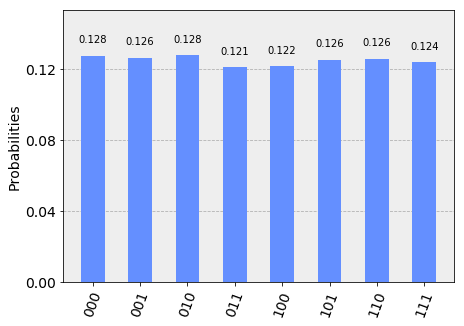

In [20]:
plot_histogram(result.get_counts(tele))

And now, calculating the percentage of shots with $|0\rangle$ measured on qubit 2 (but qubit 0 in our results).

In [21]:
counts = result.get_counts(tele)
qubit3_p0 = sum([v for k, v in counts.items() if k[0]=='0'])/10000
qubit3_p0

0.5029

Our probability of finding 0 is 50%, which is correct, because $ry(\pi / 2)$ should put qubit 0 in the $|+\rangle$ state. 

But how do we know that we're not in the $|-\rangle$ state, or any other state along the equator of the Bloch sphere? Let's use a Hadamard to see whether our phase is correct. We'll need to delete the final measurement and add the Hadamard to do this.

In [22]:
del(tele.data[-1])
tele.h(qr[2])
tele.measure(qr[2], cr[2])
tele.draw(line_length=200)

In [23]:
shots = 100000
job = execute(tele, qasm_backend, shots=shots)

result = job.result()
result.get_counts(tele)
counts = result.get_counts(tele)
qubit3_p0 = sum([v for k, v in counts.items() if k[0]=='0'])/100000
qubit3_p0

1.0

Looks like our final state is indeed $|+\rangle$, because our P($\langle\phi|H|0\rangle$) = 100%. 

# Part II: Providers and Backends - Aer, IBM Q, and 3P Providers

## Our Running Example: Phase Estimation

All this talk of checking phases is making me want to check my phases robustly. Let's see if we can work out a small phase estimation function, and sanity check it on simulators before trying it on the quantum hardware. We'll start with a QFT circuit which I've copied out of `qiskit_terra/examples/python/`. I'm also going to use the Pauli X as my controlled unitary, which simplifies things a lot. Then I'll start defining a function to give me my circuit.

In [24]:
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(np.pi / float(2**(j - k)), q[j], q[k])
        circ.h(q[j])

In [25]:
#Takes in a circuit with an operator on qubit n and appends the qpe circuit
def x_qpe(circ, q, n):
    for i in range(n-1):
        circ.h(q[i])
    for j in range(0, n-1, 2): # Only place a CX^n on every other qubit, because CX^n = I for n even
        circ.cx(q[j], q[n-1])
    circ.barrier()
    qft(circ, q, n-1)

Now let's build and print a circuit using these functions. Play around with the ancilla number, the operator, the initial state, etc. below, see what happens:

In [26]:
# n-1 is the number of ancilla
n = 4
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
x_qpe_qc = QuantumCircuit(qr, cr)
x_qpe_qc.rx(np.pi/2, qr[n-1])
x_qpe_qc.barrier()
x_qpe(x_qpe_qc, qr, n)

In [27]:
x_qpe_qc.draw(line_length=200)

Now that we have our basic algorithm, let's start trying to test and validate it in some quantum execution environments, or **backends**.

# Interlude: Providers and Backends

Qiskit offers connectors into three core execution `providers`, each providing several `backends`:

* Aer: Qiskit's suite of simulators
* BasicAer: Simple and lightweight numpy-based simulators built into Terra for convenience
* IBMQ: IBM's Quantum devices, and an HPC simulator

In addition, there are several other non-core or 3P providers:
* [QCGPU](https://qcgpu.github.io/)
* [JKU](https://github.com/Qiskit/qiskit-jku-provider)
* [ProjectQ Provider](https://github.com/Qiskit/qiskit-projectq-provider)

As we saw above, you ask a provider library for a backend object like this:
```
Aer.get_backend('statevector_simulator')
IBMQ.get_backend('ibmqx4')
```

In [28]:
from qiskit import IBMQ, Aer, BasicAer

# Aer and BasicAer Simuators

* **qasm_simulator** - cpp simulator, old faithful - a shot-based simulator
  * Input: a Qobj and execution config
  * Output: a results object containing a dictionary with basis states and shots per state
    * {‘00’: 425, ‘01’: 267, ‘11’: 90}
  * You can specify a random seed so the probabilistic measurement and noise stays the same
  * Noise - In Aer (not BasicAer), includes sophisticated noise models, which you can find more info about [here](https://github.com/Qiskit/qiskit-terra/blob/0.7.0/src/qasm-simulator-cpp/README.md) 📒
    * Unfortunately, the noise modelling in Aer does not yet have public documentation.
    * **🚨Note that non-noisy simulation runs a single monte carlo to produce the final wavefunction and samples from it randomly to produce counts. For noisy simulation we _do not_ simulate density matrices, so noisy simulation runs one monte carlo per shot and is O(shots) slower than noiseless!**
  * `pip install qiskit` comes with binaries for many platforms so you don’t need to compile cpp
  * If you’re running on another platform, check out the [Aer contributing file on github](https://github.com/Qiskit/qiskit-aer/blob/master/.github/CONTRIBUTING.md#install-from-source) for make instructions. Like any C++ compilation, it might take some finagling
* **statevector_simulator** - This is the qasm_simulator with a statevector snapshot at the end
  * Returns a result object containing a dictionary of computational basis states with **complex amplitudes** for each, not counts
* **unitary_simulator** - Returns a matrix of your circuit!
* **ibmq_qasm_simulator** - a public simulator on an HPC machine run by IBM (Note, this is under the `IBMQ Provider`)

In [29]:
backend = Aer.get_backend("qasm_simulator")
print(backend)

qasm_simulator


## The Qunatum Algorithm Testing Flow

Most of our researchers follow a sort of backend-execution-difficulty continuum as we're testing new algorithms and applications.
1. We start by testing on the statevector_simulator to verify that the algorithm works in the most idealized possible environment, and with high transparency if something is wrong
1. Then we test on the qasm_simulator with no noise, to validate that the algoirthm works in the presence of sampling noise, but not simulated physical noise. This helps us distinguish between possible sources of error. If we also tested with simulated physical noise at this stage, we'd be unable to tell whether any issues were rooted in sampling noise or physical noise.
1. Next we test in simulation with basic noise models, in most cases to obtain a very rough read of whether to spend time running on quantum hardware (because this is quite slow).
1. Finally we test our algorithm on Quantum hardware.

## Putting Our Phase Estimation Circuit Through the Gauntlet:

First, we'll run on the statevector simulator to verify that the core of our algorithm works in the ideal case, where complete state is preserved and no noise is present, including shot noise.

In [30]:
sv_backend = BasicAer.get_backend('statevector_simulator')
print(sv_backend)

statevector_simulator


In [31]:
job = execute(x_qpe_qc, sv_backend)

result = job.result()
amps = result.get_statevector(x_qpe_qc)
probs = np.absolute(amps)**2
probs_anc = probs[0:2**(n-1)] + probs[2**(n-1):]
angles = probs_anc * range(0, 2**(n-1)) / (2**(n-1))
res = 2*sum(angles)
np.around(res, decimals=5)

0.5

This is saying that our algorithm estimates the phase difference between $ry(\pi/2)|0\rangle$ and $X ry(\pi/2)|0\rangle$ to be $.5*2\pi$, or just $\pi$. We know this to be correct by thinking about the Bloch sphere.

Let's also run our single unitary on the statevector simulator to check that we have the right phase difference.

In [32]:
x_qr = QuantumRegister(1)
x_cr = ClassicalRegister(1)
x_circuit = QuantumCircuit(x_qr, x_cr)
x_circuit.rx(np.pi/2, x_qr[0])
job = execute(x_circuit, sv_backend)

result = job.result()
angles = np.angle(result.get_statevector(x_circuit))/(2*np.pi)
p0 = angles[1] - angles[0]

x_circuit.x(x_qr[0])
job = execute(x_circuit, sv_backend)

result = job.result()
angles = np.angle(result.get_statevector(x_circuit))/(2*np.pi)
p1 = angles[1] - angles[0]

difference = p1-p0

res = difference if difference > 0 else difference+1
res

0.5

👍

Now let's introduce shot noise by running on the qasm_simulator:

In [33]:
qasm_backend = Aer.get_backend('qasm_simulator')

Don't forget to measure! Recall that we don't measure our $|u\rangle$ qubit.

In [34]:
x_qpe_qc.barrier()
for i in range(n-1):
    x_qpe_qc.measure(qr[i], cr[i])

In [35]:
shots = 10000
job = execute(x_qpe_qc, qasm_backend, shots = shots)

result = job.result()
counts = result.get_counts(x_qpe_qc)
angles = np.array([v*int(k, 2) for k, v in counts.items()]) / shots / 2**(n-1)
res = 2*sum(angles)
np.around(res, decimals=5)

0.50728

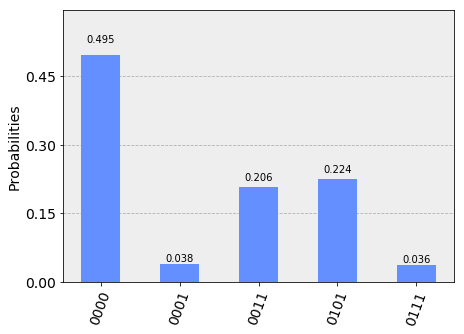

In [36]:
plot_histogram(counts)

Not bad - but this only includes shot noise. Let's introduce some physical noise into the simulation based on the callibration data from a real device.

## The IBMQ Provider: Pulling Device Information and Executing on Quantum Hardware

The IBMQ Provider has a few core functionalities:
* Providing the IBMQ quantum hardware and cloud simulator backend objects, which include hooks into the APIs necessary to interact with these execution environments
* Providing system information for user consumption and for use in transpilation (e.g. coupling map, basis set)
* Providing quantum hardware properties based on callibration data

To use the Q provider, you'll either get your Q Network API token and URL from the [console](https://q-console.mybluemix.net/) (if you are are a member of the Q Network), or you'll need to get an IBM Q Experience API token from the [Q Experience accounts page](https://quantumexperience.ng.bluemix.net/qx/account/advanced).

Below we'll obtain for a hardware backend object, pull some data, build a noise model based on the hardware data, execute a noisy simulation with our model, and finally execute on the real device.

### First, load up your Q accounts and pull the list of backends to which you have access (more info [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/basics/the_ibmq_provider.ipynb) 📒):

In [37]:
# IBMQ.enable_account('<key>')
# uncomment this ^^^ and insert your API key. Add a 'url' argument for Q Network users

# Or you can use:
IBMQ.load_accounts()

print("Available backends:")
IBMQ.backends()

Available backends:


[<IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-dev, support, default)>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(ibm-q-dev, support, default)>,
 <IBMQSimulator('ibmq_qasm_simulator') from IBMQ(ibm-q-dev, support, default)>,
 <IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQSimulator('ibmq_qasm_simulator') from IBMQ()>]

Next, let's grab a backend:

In [75]:
q_backend = IBMQ.get_backend('ibmq_16_melbourne')
# NOTE: I used a private device for the executions below

# Visualizing Devices, and Pulling Device Info

We can pull a relatively large quantity of data about a particular backend from the IBMQ API, but it's very difficult to read. Luckily, Terra has some neat built-in Jupyter magics for browsing this device information, such as qubit error, job queues for public devices, coupling maps, and more. More info [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/jupyter/jupyter_backend_tools.ipynb) 📒.

Let's start by pulling the raw data just to see what it looks like, and because we'll need it to build our noise model later:

In [76]:
configuration = q_backend.configuration()
print(configuration)

BackendConfiguration(allow_q_object=True, backend_name='ibmq_16_melbourne', backend_version='1.0.0', basis_gates=['u1', 'u2', 'u3', 'cx', 'id'], conditional=False, coupling_map=[[1, 0], [1, 2], [2, 3], [4, 3], [4, 10], [5, 4], [5, 6], [5, 9], [6, 8], [7, 8], [9, 8], [9, 10], [11, 3], [11, 10], [11, 12], [12, 2], [13, 1], [13, 12]], credits_required=True, description='14 qubit device', gates=[GateConfig(coupling_map=[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]], name='id', parameters=[], qasm_def='gate id q { U(0,0,0) q; }'), GateConfig(coupling_map=[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]], name='u1', parameters=['lambda'], qasm_def='gate u1(lambda) q { U(0,0,lambda) q; }'), GateConfig(coupling_map=[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]], name='u2', parameters=['phi', 'lambda'], qasm_def='gate u2(phi,lambda) q { U(pi/2,phi,lambda) q; }'), GateConfig(coupling_map=[[0], [1], [2], [3], [4], [5

In [77]:
properties = q_backend.properties()
print(properties)

BackendProperties(backend_name='ibmq_16_melbourne', backend_version='1.0.0', gates=[Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 4, 24, 6, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[0]), Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 4, 24, 6, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.002585646633761818)], qubits=[0]), Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 4, 24, 6, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.005171293267523636)], qubits=[0]), Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 4, 24, 6, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[1]), Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 4, 24, 6, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.011931610872511267)], qubits=[1]), Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 4, 24, 6, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0

# A Prettier Device Overview

Terra's Jupyter tools can display this in human-readable format. Note that explanations of much of the data below can be found in the [Qiskit Backend Specifications for OpenQASM and OpenPulse Experiments](https://arxiv.org/abs/1809.03452) paper.

In [78]:
from qiskit.tools.jupyter import *

In [61]:
%qiskit_backend_overview

# Diving into a Specific Backend

In [79]:
%qiskit_backend_monitor q_backend

# Modelling Noise in Aer Based on a Device's Properties

Now that we have these properties, we want to create a noise model for the qasm_simulator which closely resembles this device. A new feature in Aer allows you to do just that. Much of the content below is drawn from [this notebook](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aer/device_noise_simulation.ipynb) 📒.

In [63]:
from qiskit.providers.aer import noise

In [64]:
# List of gate times for ibmq_14_melbourne device
# Note that the None parameter for u1, u2, u3 is because gate
# times are the same for all qubits
gate_times = [
    ('u1', None, 0), ('u2', None, 50), ('u3', None, 100),
    ('cx', [1, 0], 478), # I can add gate times for specific couplings, or all couplings
    ('cx', [], 400)
]

# Construct the noise model from backend properties
# and custom gate times
noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)
print(noise_model)

NoiseModel:
  Instructions with noise: ['u3', 'u2', 'measure', 'cx']
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u2', [14]), ('u2', [15]), ('u2', [16]), ('u2', [17]), ('u2', [18]), ('u2', [19]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('u3', [14]), ('u3', [15]), ('u3', [16]), ('u3', [17]), ('u3', [18]), ('u3', [19]), ('cx', [0, 1]), ('cx', [0, 5]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [2, 3]), ('cx', [3, 2]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [4, 9]), ('cx', [5, 0]), ('cx', [5, 6]), ('cx', [5, 10]), ('cx', [6, 5]), ('cx', [6, 7]), ('cx', [7, 6]), ('cx', [7, 8]), ('cx', [7, 12]), ('cx', [8, 7]), ('cx', [8, 9]), ('cx', [9, 4]), ('cx', [9, 8]), ('cx', [9, 

# Executing Our QPE Circuit with Our Noise Model

Now, let's use this model to simulate our QPE circuit. Note, this can take a few minutes to run.

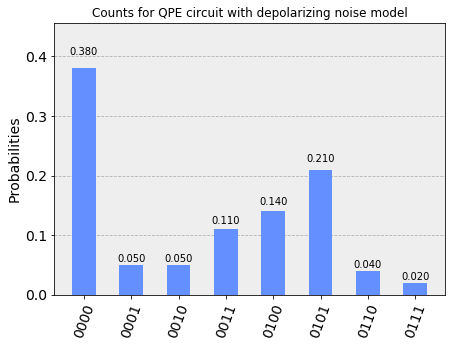

In [65]:
shots = 100
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')
coupling_map = configuration.coupling_map

# Execute noisy simulation and get counts
result_noise = execute(x_qpe_qc, simulator, 
                       shots=shots,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(x_qpe_qc)
plot_histogram(counts_noise, title="Counts for QPE circuit with depolarizing noise model")

In [66]:
# And now our phase estimate:
angles = np.array([v*int(k, 2) for k, v in counts_noise.items()]) / shots / 2**(n-1)
res = 2*sum(angles)
np.around(res, decimals=5)

0.6175

This is not great (we'll investigate why in a moment), but let's try running on the **Qauntum hardware anyway 🌈**.

# Executing on Quantum Hardware

### Back again to our circuit:

In [67]:
x_qpe_qc.draw(line_length=200)

Let's briefly peek at what the transpiler does to the circuit to allow it to execute on our selected device:

In [68]:
chewed_x_qpe = transpile(x_qpe_qc, q_backend)
chewed_x_qpe.draw(line_length=400)

# Now, Executing Our Circuit:

In [69]:
shots = 8192        # Number of shots to run the program (experiment); maximum is 8192 shots.
job_exp = execute(x_qpe_qc, q_backend, shots = shots)

In [70]:
# Check the job status
job_exp.status()

<JobStatus.INITIALIZING: 'job is being initialized'>

# 🚨Note🚨: 'job is actively running' includes waiting in the queue!

Note that I increase the timeout and wait time below considerably - this is completely necessary. The defaults are way too short.

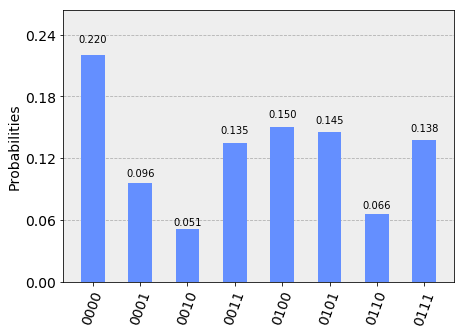

In [71]:
# We recommend increasing the timeout to 30 minutes to avoid timeout errors when the queue is long.
result_real = job_exp.result(timeout=3600, wait=5)
counts = result_real.get_counts(x_qpe_qc)
plot_histogram(counts)

In [72]:
angles = np.array([v*int(k, 2) for k, v in counts.items()]) / shots / 2**(n-1)
res = 2*sum(angles)
np.around(res, decimals=5)

0.82169

Uh... not ideal, but the important peaks are coming through. More work to do...

FYI, you can also retrieve an old job by its job_id.

In [73]:
jobID = job_exp.job_id()

print('JOB ID: {}'.format(jobID))

job_get=q_backend.retrieve_job(jobID)
job_get.result().get_counts(x_qpe_qc)

JOB ID: 5cc05ec41aa79a006f46c0fa


{'0001': 784,
 '0000': 1801,
 '0100': 1229,
 '0010': 416,
 '0101': 1188,
 '0110': 541,
 '0111': 1127,
 '0011': 1106}

# Tips and tricks

* Put many circuits into a single execution!
  * Simulators will (generally) execute these in parallel
  * Quantum Hardware does a lot of calibration for each new job, so if you send 100 jobs it will generally take ~100x as long as one job with 100 circuits, even if the circuits are completely different!
* Increase your timeout when waiting for results! Default is 30 seconds, better to set to 1800 (30 mins)
  * See notebook above (ctrl-f for 'timeout')
* Consider commenting out Qobj validation if you need more speed in an iterative algo, but don’t tell anyone who told you so!
* Use an IDE!! A lot of people at IBM use Pycharm. Being able to step through the code is critical!

* Look at the debug log messages. There is a ton of important info in there.
  * Even better, save them to a file.

In [74]:
import logging
logging.getLogger('qiskit').setLevel(logging.DEBUG)

Redirecting logs to a file:

```
# Redirecting debug logs to a file (can't be done in colab):
    loggerc = logging.getLogger('qiskit_aqua_chemistry')
    loggerc.setLevel(logging.DEBUG)
    loggera = logging.getLogger('qiskit_aqua')
    loggera.setLevel(logging.DEBUG)
    loggerq = logging.getLogger('qiskit')
    loggerq.setLevel(logging.DEBUG)
    formatter = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    hdlr = logging.FileHandler(outdir + log_file_name, mode='w')
    hdlr.setFormatter(formatter)
    loggerc.addHandler(hdlr)
    loggera.addHandler(hdlr)
    loggerq.addHandler(hdlr)
    print('\nlog file: {}'.format(outdir + log_file_name))
# <build, execute, etc.>
# close up handlers
    loggerc.removeHandler(hdlr)
    loggera.removeHandler(hdlr)
    loggerq.removeHandler(hdlr)
    hdlr.close()
```

Handling errors from the hardware and APIs is hard! Don't reinvent the wheel. The Aqua team have built a sophisticated system for robust and fault-resilient execution. I highly recommend you use it, or copy its methods: [run_circuits.py](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/utils/run_circuits.py)

# Learning more

The [qiskit-tutorials](https://github.com/Qiskit/qiskit-tutorials) 📒 repo on Github has dozens of thoughtful and sophisticated tutorials. I highly recommend going through both the “[qiskit/](https://github.com/Qiskit/qiskit-tutorials/tree/master/qiskit)” directory and the “[community/](https://github.com/Qiskit/qiskit-tutorials/tree/master/community)” directory. I learn new things every time I look through them, and reference them regularly.

The order in which I investigate if I'm confused about something:
* Look at the tutorials for an example
* Look at the code directly to understand the behavior
* Look at the tests for an example
* Debug in my IDE, relying heavily on inspecting objects during execution
* Look at the documentation

# Review - Quantum Algorithm Building Blocks

Four major building blocks of quantum algorithms:

* Quantum Fourier Transform
   * Period-finding and phase↔norm swapping
   * Speedup from O(n2n) to O(n2)
   * E.g. Shor’s algorithm, Quantum Phase Estimation
* Hamiltonian Evolution
   * Applying a Hamiltonian to an initial state over an arbitrary time period
   * Exponential speedup (mostly, with complicated factors)
   * E.g. HHL, QAOA, QPE
* Unstructured Search (Grover’s)
   * Search for a state (string) exhibiting a binary condition (e.g. satisfy my 3SAT problem…)
   * Speedup of O(√n)
* Variational Optimization
   * Prepare a quantum state using a parameterized short circuit, use a classical optimizer to optimize parameters toward some desired quality evaluated on the QC (e.g. binary classification)
   * Speedups vary, usually no guaranteed speedup, but good for NISQ machines
   * E.g. VQE, VSVM, QAOA

# Quantum Fourier Transform

We've used it above and it is straightforward to implement, but it is not very intuitive as a building block, and I recommend the [tutorial dedicated to it](https://github.com/Qiskit/qiskit-tutorial/blob/master/community/terra/qis_adv/fourier_transform.ipynb) 📒 by Anna Phan. I also highly recommmend 3Blue1Brown's video on the [continuous fourier transform](https://www.youtube.com/watch?v=spUNpyF58BY).

# Hamiltonian Evolution

This is trickier, we're working on it. For now, the best way to learn about this in Qiskit is in the [Aqua operator class](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/operator.py#L1119), which includes lots of evolution logic.

# Grover’s Algorithm

Pretty straightforward in Terra. See [this notebook](https://github.com/Qiskit/qiskit-tutorial/blob/master/community/algorithms/grover_algorithm.ipynb) 📒 by Giacomo Nannicini and Raymond Harry Rudy.



# Variational Optimization

This also doesn't have a standalone tutorial, but the [Aqua VQE](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/algorithms/adaptive/vqe/vqe.py) is a straightforward, well engineered example of variational optimization. The [Aqua Variational SVM](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/algorithms/adaptive/qsvm/qsvm_variational.py) is also a good example.

# Learning More - A Longer Course

[This doc](https://docs.google.com/document/d/1WoUQky2NXdbrdGkxaUA28VE7W3fryTQG6ezn8Fw-l4E/edit) details a longer course to fluency in Quantum Programming.